# Introduction

Welcome to our end-to-end example of Passport Data Extraction with Face Segment Output. In this demo, we will demonstrate how to use this sagemaker model for passport data extraction, and face segment output. 

# Prequisites and Preprocessing

## Creating the endpoint with subscribed image

Before you start, you should already subscribe to [our model package](https://aws.amazon.com/marketplace/pp/prodview-rwowi35gavzww) from AWS Marketplace. Upon a successful 
Under your AWS account's AWS Marketplace subscriptions, you will see 'Passport Verification' is shown there. By clicking this subscribed model packages, you will be able to create the endpoint/create the model like below, by selecting the model package and click 'actions' -> 'create endpoint'.

![Endpoint Creation Guide](doc_image/sagemaker-endpoint-creating.png)

Inside create endpoint menu, you could name the endpoint as you wish, and record the endpoint name for reference purpose. Next, we would show you how to encode your image and use the endpoint.

## Preparing the image and encoding the image
Let's use this sample image as an example. You may find this image in the sample image folder in our [github repository](https://github.com/gtriip/sagemaker-sample-inference-notebook.git).
Basically, the requirement to the images are:
1. Clear enough so that MRZ code are visible;
2. Passport should be the main object in the image, occupying the most space;
3. Image should have a clear background, especially need to be clear from other text in the background, else the model would fail in locating the location of MRZ;
4. Whether the passport is half (only biodata page) or full doesn't matter.

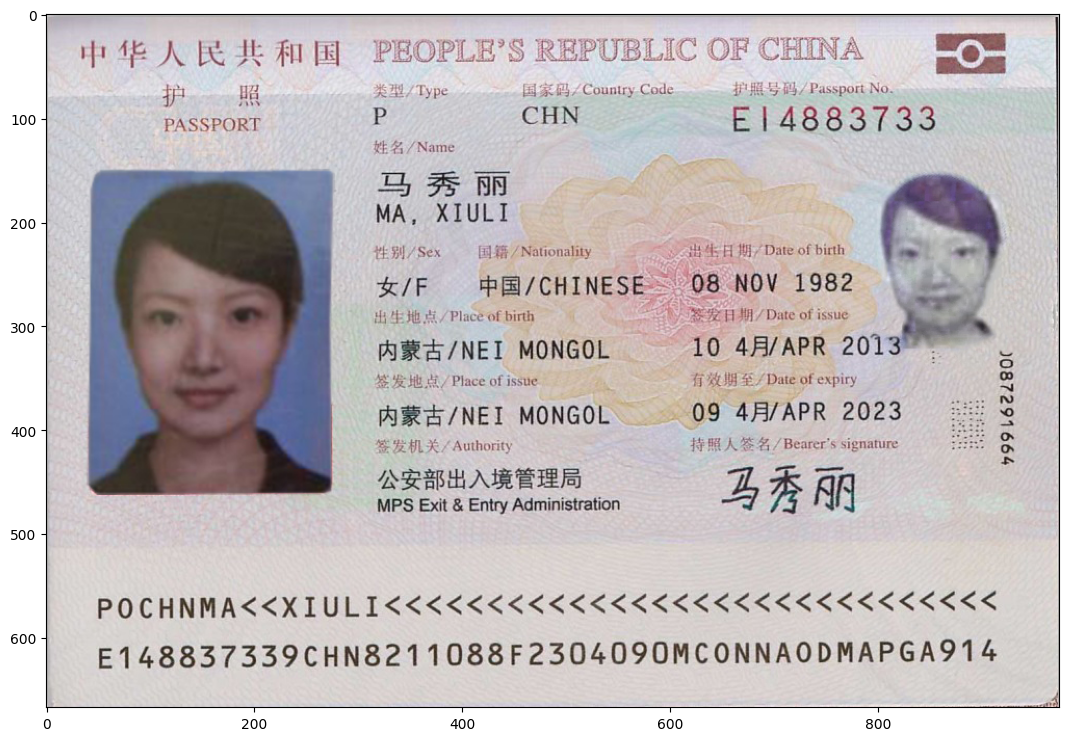

In [1]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

# For better displaying...
plt.rcParams["figure.figsize"] = (16, 9)

# Specify the image path
image_path = 'sample_image/passport_34.png'

# Read image, and change colorspace for showing
passport_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
passport_image = cv2.cvtColor(passport_image, cv2.COLOR_BGR2RGB)

# Display using pyplot
img_plot = plt.imshow(passport_image)

Next, we would encode it in base64 format, and wrap this request into a JSON file format for requesting.

In [2]:
import base64
import json

# Encode the image file data
with open(image_path, 'rb') as image_file:
    image_bytes = image_file.read()

image_bytes_encoded = base64.b64encode(image_bytes)

# Wrap in JSON format to pass to the engine. 
# Because JSON requires non-bytes, we would need to decode it again using 'utf-8'
request_dict = {"image_bytes": image_bytes_encoded.decode('utf-8'), "auto_rotate": True}
request_json = json.dumps(request_dict, indent=4)

With this preparation of image done, we can launch the request in the next step.

# Requesting and Result Handling

With the endpoint created in your aws account, and you setup the credentials in `/.aws/` folder properly, you could easily launch requests using the following block of code:

In [3]:
import boto3
import pprint

client = boto3.client('sagemaker-runtime')

# Your endpoint name
endpoint_name = "passport-verification-endpoint"
# content_type and accept MIME type are both "application/json"
content_type = "application/json"
accept = "application/json"
payload = request_json

response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType=content_type, 
    Accept=accept, 
    Body=payload
)

pprint.pprint(response)

{'Body': <botocore.response.StreamingBody object at 0x76f1543ef520>,
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'default-variant-name',
 'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '19172',
                                      'content-type': 'application/json',
                                      'date': 'Thu, 27 Jun 2024 09:18:07 GMT',
                                      'x-amzn-invoked-production-variant': 'default-variant-name',
                                      'x-amzn-requestid': '4dcdfd03-9790-4210-aefd-251fbd06f082'},
                      'HTTPStatusCode': 200,
                      'RequestId': '4dcdfd03-9790-4210-aefd-251fbd06f082',
                      'RetryAttempts': 0}}


We successfully get response from the server. Next, we'll use json.loads to read the result back into a dictionary, and we would be able to use the corresponding results afterwards.

In [4]:
import pprint
pprinter = pprint.PrettyPrinter(indent=0)
result_content = json.loads(response['Body'].read().decode('utf-8'))
pprinter.pprint(result_content)

{'face_segment': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAExAMgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDOBkxhhnFM2gcleexxVhmjiPmFc54GKU3FuykmPH1r9UhUlOVuU+W5vIpytukBAGPUUSAFPM7etSk26r5ix/L3qPUb+10+0+1XZAjAzg1tUrQo025aEcq5roqarq1rp0AkLAcdSa808e/GC30wukEyng

You could then refer to the valid_score as a reference of the recognition quality, rejecting a recognition when it's lower than your threshold in case an unwanted result is reached in the end. Next, let's see how should we use the returned face_location.

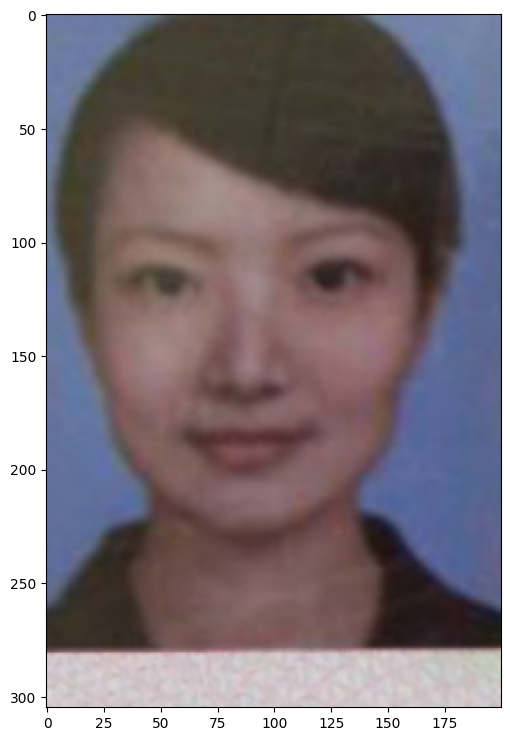

In [5]:
import numpy as np

face_encoded = result_content['face_segment']
face_nparr = np.frombuffer(base64.b64decode(face_encoded), np.uint8)
face_image = cv2.imdecode(face_nparr, cv2.IMREAD_ANYCOLOR)
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

# Display using pyplot
img_plot = plt.imshow(face_image)

# Auto-Rotation
Starting from version 1.1.1, we support a new field called `auto_rotate` in the requests. This feature addresses instances where the user submits the passport image in an incorrect orientation. The engine will automatically rotate the image for scanning and provide a recommended angle in the response. You can use this angle to adjust your image accordingly. Here's an example:

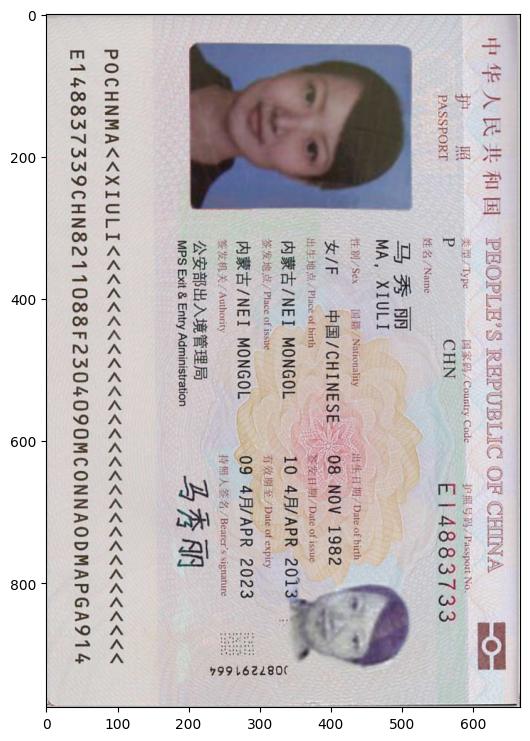

In [6]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

# For better displaying...
plt.rcParams["figure.figsize"] = (16, 9)

# Specify the image path
image_path = 'sample_image/passport_34_rotated.png'

# Read image, and change colorspace for showing
passport_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
passport_image = cv2.cvtColor(passport_image, cv2.COLOR_BGR2RGB)

# Display using pyplot
img_plot = plt.imshow(passport_image)

In [7]:
import base64
import json

# Encode the image file data
with open(image_path, 'rb') as image_file:
    image_bytes = image_file.read()

image_bytes_encoded = base64.b64encode(image_bytes)

# Wrap in JSON format to pass to the engine. 
# Because JSON requires non-bytes, we would need to decode it again using 'utf-8'
request_dict = {"image_bytes": image_bytes_encoded.decode('utf-8'), "auto_rotate": True}
request_json = json.dumps(request_dict, indent=4)

In [8]:
# Your endpoint name
endpoint_name = "passport-verification-endpoint"
# content_type and accept MIME type are both "application/json"
content_type = "application/json"
accept = "application/json"
payload = request_json

response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType=content_type, 
    Accept=accept, 
    Body=payload
)

pprint.pprint(response)

{'Body': <botocore.response.StreamingBody object at 0x76f1484dc640>,
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'default-variant-name',
 'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '19222',
                                      'content-type': 'application/json',
                                      'date': 'Thu, 27 Jun 2024 09:18:12 GMT',
                                      'x-amzn-invoked-production-variant': 'default-variant-name',
                                      'x-amzn-requestid': 'd5d14f44-a58a-4c51-b279-5e643cfc4e98'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'd5d14f44-a58a-4c51-b279-5e643cfc4e98',
                      'RetryAttempts': 0}}


In [9]:
import pprint
pprinter = pprint.PrettyPrinter(indent=0)
result_content = json.loads(response['Body'].read().decode('utf-8'))
pprinter.pprint(result_content)

{'face_segment': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAExAMgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDOBcDDDOKZtK/MU5PQ7asM0cR8wjOeKU3UDKS0dfqkKkpu3KfLc3kU5XBcHjFLKB5fmYGPWpGaAL5qxYXOCKi1LULTTrP7XdkBMZINbVa0KMHzaEcqcroqatrFrp0AkLAcdTXmPj74w2+nF4oJwTg9DW

We can see that there is a rotate angle of -90, and the face segment is in the correct direction.

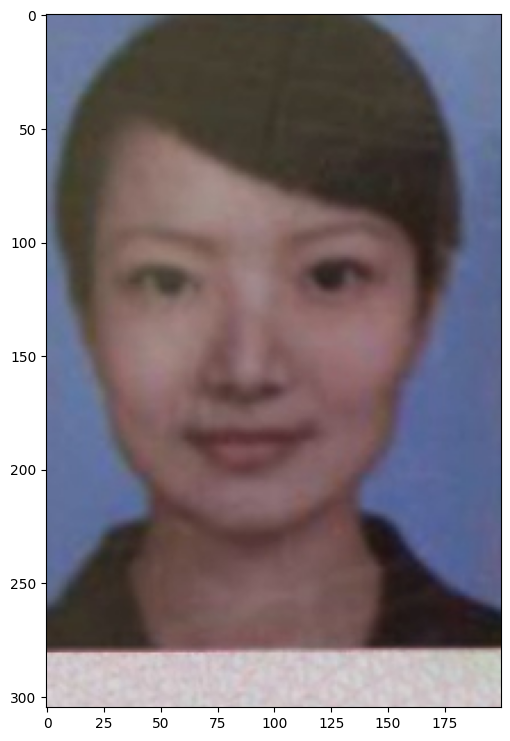

In [10]:
import numpy as np

face_encoded = result_content['face_segment']
face_nparr = np.frombuffer(base64.b64decode(face_encoded), np.uint8)
face_image = cv2.imdecode(face_nparr, cv2.IMREAD_ANYCOLOR)
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

# Display using pyplot
img_plot = plt.imshow(face_image)

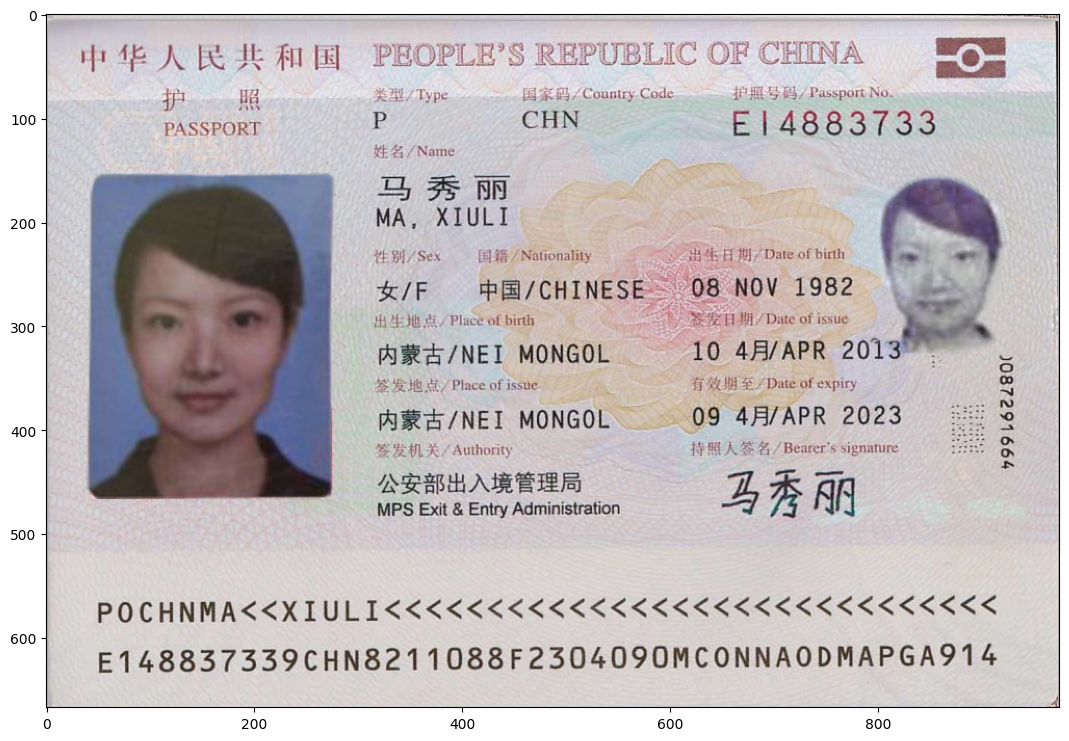

In [11]:
import imutils
from matplotlib import pyplot as plt
%matplotlib inline

rotated_image = imutils.rotate_bound(passport_image, result_content['rotate_angle'])

# Display using pyplot
img_plot = plt.imshow(rotated_image)

# Error Code and Message Mapping

In the case of a failed recognition, different types of error message and error codes would be returned. Let's try a failed case (passport image with no face) for a basic understanding.

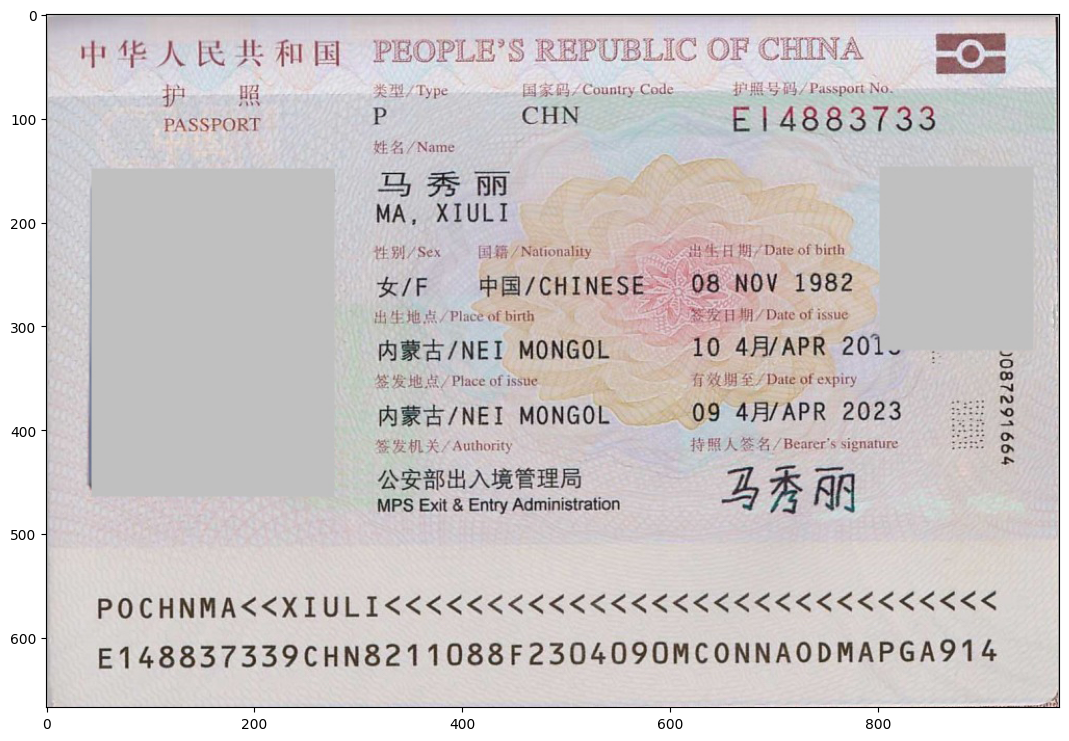

In [12]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

# For better displaying...
plt.rcParams["figure.figsize"] = (16, 9)

# Specify the image path
image_path = 'sample_image/passport_34_no_face.png'

# Read image, and change colorspace for showing
passport_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
passport_image = cv2.cvtColor(passport_image, cv2.COLOR_BGR2RGB)

# Display using pyplot
img_plot = plt.imshow(passport_image)

In [13]:
import base64
import json

# Encode the image file data
with open(image_path, 'rb') as image_file:
    image_bytes = image_file.read()

image_bytes_encoded = base64.b64encode(image_bytes)

# Wrap in JSON format to pass to the engine. 
# Because JSON requires non-bytes, we would need to decode it again using 'utf-8'
request_dict = {"image_bytes": image_bytes_encoded.decode('utf-8')}
request_json = json.dumps(request_dict, indent=4)

In [14]:
import boto3

client = boto3.client('sagemaker-runtime')

# Your endpoint name
endpoint_name = "passport-verification-endpoint"
# content_type and accept MIME type are both "application/json"
content_type = "application/json"
accept = "application/json"
payload = request_json

response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType=content_type, 
    Accept=accept, 
    Body=payload
)

pprint.pprint(response)

{'Body': <botocore.response.StreamingBody object at 0x76f1543ee020>,
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'default-variant-name',
 'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '106',
                                      'content-type': 'application/json',
                                      'date': 'Thu, 27 Jun 2024 09:18:18 GMT',
                                      'x-amzn-invoked-production-variant': 'default-variant-name',
                                      'x-amzn-requestid': 'bae38e09-c3d5-461e-9bc4-55dc09f3f945'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'bae38e09-c3d5-461e-9bc4-55dc09f3f945',
                      'RetryAttempts': 0}}


In [15]:
import pprint
pprinter = pprint.PrettyPrinter(indent=0)
result_content = json.loads(response['Body'].read().decode('utf-8'))
pprinter.pprint(result_content)

{'errorCode': '011',
'errorMessage': 'Face image is required but not found in the document.',
'success': False}


Then we can try to add `skip_face_check` field.

In [16]:
# Encode the image file data
with open(image_path, 'rb') as image_file:
    image_bytes = image_file.read()

image_bytes_encoded = base64.b64encode(image_bytes)

# Wrap in JSON format to pass to the engine. 
# Because JSON requires non-bytes, we would need to decode it again using 'utf-8'
request_dict = {"image_bytes": image_bytes_encoded.decode('utf-8'), "skip_face_check": True}
request_json = json.dumps(request_dict, indent=4)

In [17]:
import boto3

client = boto3.client('sagemaker-runtime')

# Your endpoint name
endpoint_name = "passport-verification-endpoint"
# content_type and accept MIME type are both "application/json"
content_type = "application/json"
accept = "application/json"
payload = request_json

response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType=content_type, 
    Accept=accept, 
    Body=payload
)

pprint.pprint(response)

{'Body': <botocore.response.StreamingBody object at 0x76f1483cc790>,
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'default-variant-name',
 'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '681',
                                      'content-type': 'application/json',
                                      'date': 'Thu, 27 Jun 2024 09:18:22 GMT',
                                      'x-amzn-invoked-production-variant': 'default-variant-name',
                                      'x-amzn-requestid': 'dc04bba7-1981-453a-a070-5789ebd777fb'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'dc04bba7-1981-453a-a070-5789ebd777fb',
                      'RetryAttempts': 0}}


In [18]:
result_content = json.loads(response['Body'].read().decode('utf-8'))
pprint.pprint(result_content)

{'result': {'check_composite': '4',
            'check_date_of_birth': '8',
            'check_expiration_date': '0',
            'check_number': '9',
            'check_personal_number': '1',
            'country': 'China',
            'date_of_birth': '1982-11-08',
            'document_type': 'passport',
            'expiration_date': '2023-04-09',
            'expired': True,
            'first_name': 'Xiuli',
            'last_name': 'Ma',
            'mrz_type': 'TD3',
            'nationality': 'China',
            'number': 'E14883733',
            'personal_number': 'MC0NNA0DMAPGA9',
            'raw_text': 'POCHNMA<<XIULI<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<\n'
                        'E148837339CHN8211088F2304090MC0NNA0DMAPGA914',
            'sex': 'Female',
            'type': 'PO',
            'valid_composite': False,
            'valid_date_of_birth': True,
            'valid_expiration_date': True,
            'valid_number': True,
            'valid_personal_number': False,


You could see it's `error_code` 011 in the beginning, with `error_message` Face not found, invalid passport document. The mapping of all `error_code` and `error_message` can be find in the following table:

| error_code | error_message | condition |
|---|---|---|
| 001 | API key is either missing or incorrect. | This is impossible to occur in sagemaker context. |
| 002 | Error reading image, please check request format. | When there is error in reading the image from the request, this would occur. Please check if image is encoded correctly, or if it's corrupted. |
| 003 | Image file size exceeded the limit, please resize before uploading. | This means the image size exceeded 10MB, please resize before sending the request. |
| 004 | Request is not in the correct format. | Error occurred while trying to format the request, maybe some important field like `image` or `image_bytes` is missing. |
| 005 | Server internal error, please try again. | There's some exception inside the server, please check the server logs. This shall be rare. |
| 011 | Face image is required but not found in the document. | `skip_face_check` is false, however, face is not detected in the image. |
| 012 | MRZ code is of a different type, please try again. | MRZ code is found, but it's not passport's PD2 type. Either it's a visa, or it's some other travel document. |
| 013 | Error reading MRZ code, please try again. | Exception happened while reading MRZ code, please try again. |
| 014 | Error parsing MRZ code, please ensure there are no obstacles or glare on the bottom code portion. | MRZ code is either not found, or with too low validity. |
| 015 | Passport specimen detected. | *Not implemented*. |
| 016 | MRZ code check failed, please try again. Ensure there are no obstacles or glare on the bottom code portion. | MRZ parsing failed, some characters may be blocked in the image. |

In the case that more help and explanation is needed, please contact Frosty at [Frosty](mailto:frosty@gtriipglobal.com)